In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [1]:
from matchup_analysis import build_feature_dataframe_from_parsed
df = build_feature_dataframe_from_parsed(parsed_folder="parsed_matches", champ_data_path="champ_data.csv")
df.to_csv("features_all_matches.csv", index=False, encoding="utf-8")
import matplotlib.pyplot as plt
df.head()
#df.tail()


Récupération des données items via DataDragon...
(47595, 7)


,Champion,Role,Adversaire,Dégat de l'adversaire,Gold,Item actuel,Next item
47590,Twitch,BOTTOM,Vayne,AD,7626,Yun Tal Wildarrows,Runaan's Hurricane
47591,Twitch,BOTTOM,Vayne,AD,11989,Runaan's Hurricane,Infinity Edge
47592,Lulu,UTILITY,Yuumi,AP,3991,None,Ardent Censer
47593,Lulu,UTILITY,Yuumi,AP,5540,Ardent Censer,Crimson Lucidity
47594,Lulu,UTILITY,Yuumi,AP,7390,Crimson Lucidity,Shurelya's Battlesong


Formulation du problème

Tâche : classification multi-classe — prédire 1 item parmi N (N = nombre d'items finals observés).

Entrée (contexte) possible : séquence d'items déjà achetés (ou uniquement dernier item), champion joué, champion adverse, rôle (lane), gold et possiblement plus

Sortie : probas sur le vocabulaire d'items; on utilise top-k accuracy (k=1,3,5) comme métriques principales.

C:\Users\preda\AppData\Local\Temp\ipykernel_25972\784156148.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis')


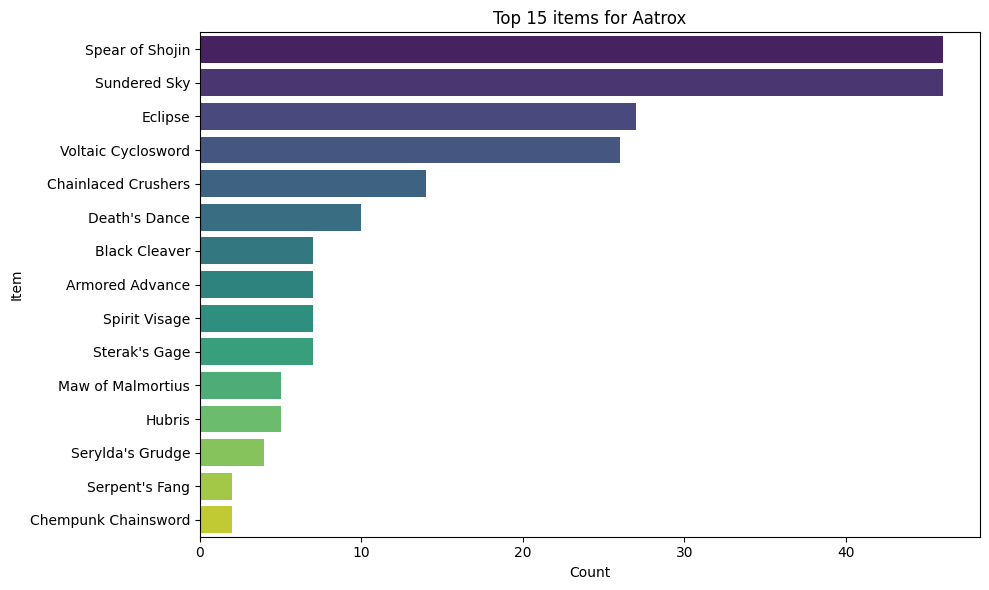

In [ ]:
# Fonction de visualisation des top-N items
def plot_top_items(df, champion=None, topn=20, column='Next item'):
    """
    Bar plot des top-N items (globaux ou filtrés par champion).
    """
    sub = df if champion is None else df[df['Champion'] == champion]
    counts = sub[column].value_counts().nlargest(topn)
    plt.figure(figsize=(10,6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Item')
    title = f"Top {topn} items"
    if champion: title += f" for {champion}"
    plt.title(title)
    plt.tight_layout()

# Example:
plot_top_items(df, champion='Aatrox', topn=15)

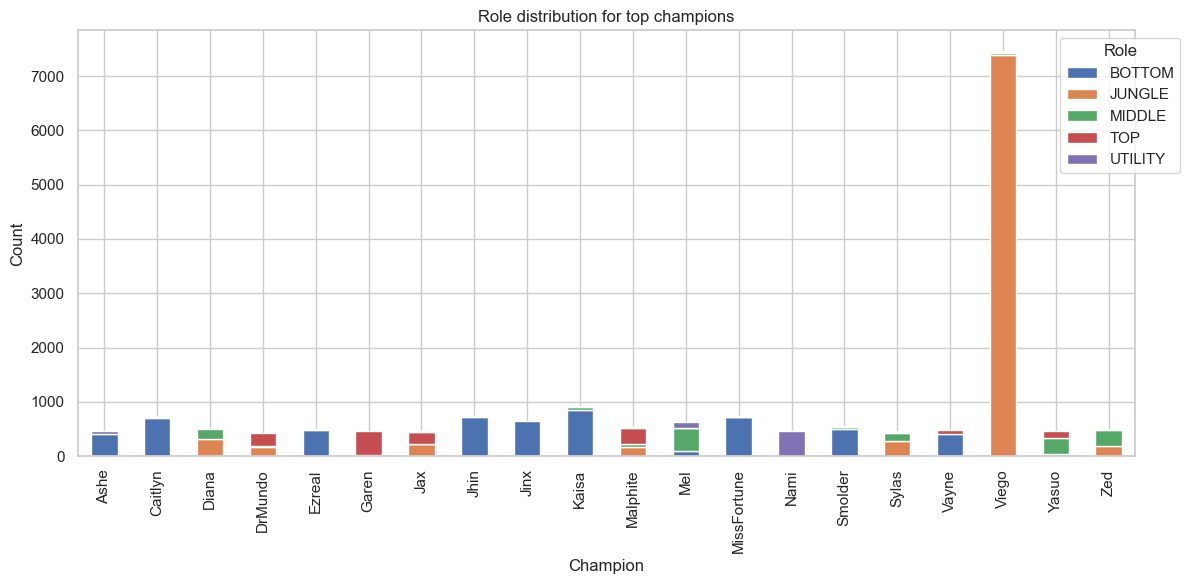

In [24]:
# permet de voir comment se répartissent les rôles pour les champions les plus joués 
# (beaucoup d'adc car peu de champions en bottom et wtf viego)
def plot_role_distribution(df, champion=None, topn=10):
    """
    Affiche la distribution des rôles pour les champions les plus fréquents
    ou pour un champion donné.
    """
    if champion:
        pivot = df[df['Champion'] == champion].groupby('Role')['Next item'].count().sort_values(ascending=False)
        pivot.plot(kind='bar', figsize=(6,4))
        plt.title(f"Role distribution for {champion}")
        plt.ylabel('Count')
    else:
        top_champs = df['Champion'].value_counts().nlargest(topn).index
        sub = df[df['Champion'].isin(top_champs)]
        pivot = sub.groupby(['Champion','Role']).size().unstack(fill_value=0)
        pivot.plot(kind='bar', stacked=True, figsize=(12,6))
        plt.title("Role distribution for top champions")
        plt.ylabel('Count')
        plt.legend(title='Role', bbox_to_anchor=(1.05,1))
    plt.tight_layout()

# Example:
plot_role_distribution(df, topn=20)
# plot_role_distribution(df, champion='Aatrox')

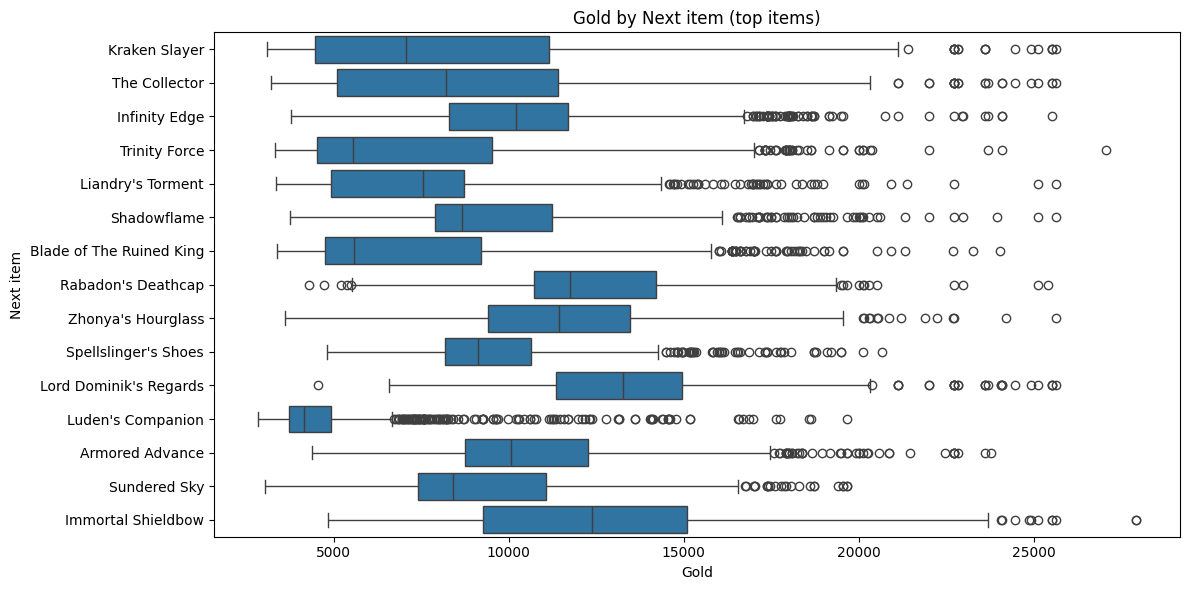

In [ ]:
# permet de voir quand sont achetés les items (au début avec les premiers golds ou à la fin)
def plot_gold_by_item(df, item_col='Next item', topn=20):
    top_items = df[item_col].value_counts().nlargest(topn).index
    sub = df[df[item_col].isin(top_items)]
    plt.figure(figsize=(12,6))
    sns.boxplot(y=item_col, x='Gold', data=sub, order=top_items)
    plt.title('Gold by Next item (top items)')
    plt.tight_layout()

# Example:
plot_gold_by_item(df, topn=15)

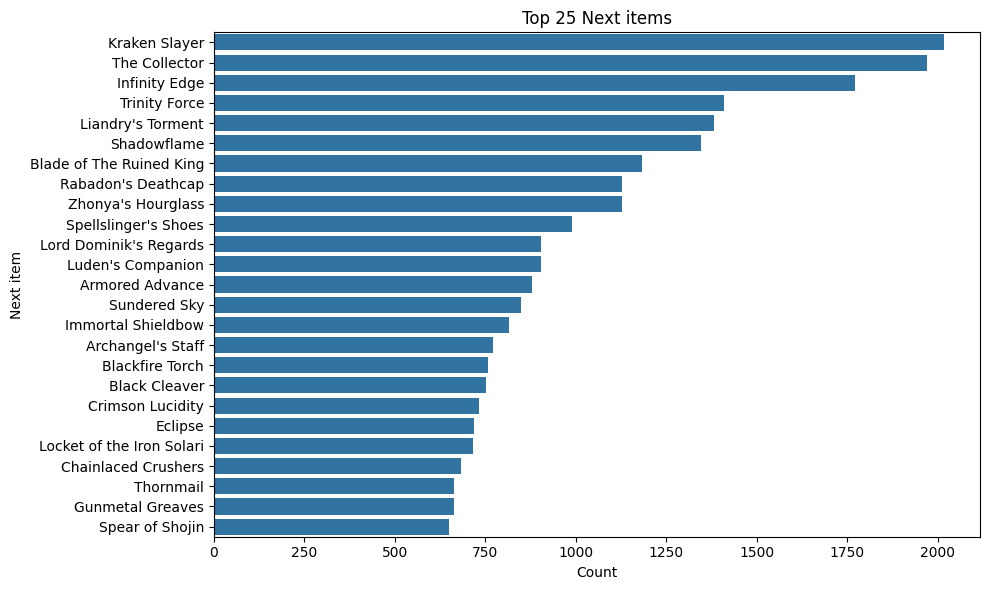

In [ ]:
# voir la popularité des items achetés
def plot_next_item_counts(df, topn=30):
    counts = df['Next item'].value_counts().nlargest(topn)
    plt.figure(figsize=(10,6))
    sns.barplot(x=counts.values, y=counts.index)
    plt.title(f'Top {topn} Next items')
    plt.xlabel('Count')
    plt.tight_layout()

# Example:
plot_next_item_counts(df, topn=25)

In [ ]:
# pas fou, on peut voir une corrélation entre manamune et ez par exemple, mais bcp trop grand pour l'instant

def plot_correlation_heatmap(df, categorical_cols=None, numeric_cols=None, encode='onehot', method='pearson', topk_categories=50):
    """
    - encode: 'onehot' ou 'label'
    - method: 'pearson' or 'spearman'
    - topk_categories: si onehot, garder top-K valeurs par catégorie (remplacer le reste par 'OTHER') pour éviter explosion
    """
    df = df.copy()

    if numeric_cols is None:
        # essayer de détecter colonnes numériques
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if categorical_cols is None:
        categorical_cols = [c for c in df.columns if c not in numeric_cols]

    # Prepare categorical subset
    cat_df = pd.DataFrame(index=df.index)
    for c in categorical_cols:
        if encode == 'onehot':
            # reduce cardinality
            top_vals = df[c].value_counts().nlargest(topk_categories).index
            series = df[c].where(df[c].isin(top_vals), other='OTHER').fillna('UNKNOWN')
            dummies = pd.get_dummies(series, prefix=c)
            cat_df = pd.concat([cat_df, dummies], axis=1)
        else:  # label
            series = df[c].fillna('UNKNOWN').astype(str)
            le = pd.factorize(series)[0]  # faster than sklearn for quick viz
            cat_df[c] = le

    num_df = df[numeric_cols].copy()

    # combine
    combined = pd.concat([num_df, cat_df], axis=1).fillna(0)

    # compute correlation matrix
    corr = combined.corr(method=method)

    # plot heatmap (size driven by number of columns)
    plt.figure(figsize=(min(20, 0.25*corr.shape[0]), min(20, 0.25*corr.shape[1])))
    sns.heatmap(corr, cmap='RdBu_r', center=0, vmin=-1, vmax=1, linewidths=.5)
    plt.title(f'Correlation heatmap ({method}) over numeric + encoded categorical features')
    plt.tight_layout()

# Example:
# plot_correlation_heatmap(df, categorical_cols=['Champion','Role','Adversaire','Item actuel','Next item'], numeric_cols=['Gold'], encode='onehot', method='pearson', topk_categories=40)

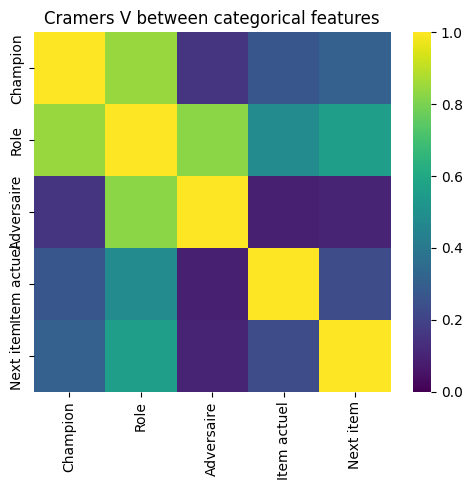

In [ ]:
import scipy.stats as ss

#Heatmap de corrélation de variables catégorielles
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)+1e-9))

def category_heatmap(df, cats, topk=30):
    cats = list(cats)
    m = np.zeros((len(cats), len(cats)))
    for i,a in enumerate(cats):
        for j,b in enumerate(cats):
            m[i,j] = cramers_v(df[a].fillna('NA'), df[b].fillna('NA'))
    plt.figure(figsize=(len(cats), len(cats)))
    sns.heatmap(m, xticklabels=cats, yticklabels=cats, cmap='viridis', vmin=0, vmax=1)
    plt.title("Cramers V between categorical features")
    plt.tight_layout()

# Example:
category_heatmap(df, ['Champion','Role','Adversaire','Item actuel','Next item'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Prépare les colonnes et nettoie les valeurs manquantes comme lors de l'entraînement
df = df.dropna(subset=["Next item"])
df['Item actuel'] = df['Item actuel'].fillna('None')
df['Role'] = df['Role'].fillna('Unknown')
df['Adversaire'] = df['Adversaire'].fillna('Unknown')

FEATURE_COLS = ['Champion', 'Role', 'Adversaire', 'Item actuel', 'Gold']
X = df[FEATURE_COLS]
y = df['Next item']

# encoder la cible
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)
print("Nombre de classes (items):", len(le_y.classes_))

# encoder catégoriels + scaler numérique (compatible scikit-learn versions)
categorical_cols = ['Champion', 'Role', 'Adversaire', 'Item actuel']
numeric_cols = ['Gold']

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(transformers=[
    ('cat', ohe, categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

print("Fitting preprocessor...")
X_proc = preprocessor.fit_transform(X)
print("X_proc shape:", X_proc.shape)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)

# train
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')
print("Training RandomForest...")
clf.fit(X_train, y_train)
print("Training done.")

In [ ]:
def top_k_accuracy(clf, X, y, k=3):
    probs = clf.predict_proba(X)
    topk = np.argsort(probs, axis=1)[:, ::-1][:, :k]
    return np.mean([y[i] in topk[i] for i in range(len(y))])

In [ ]:
print("Top-1:", top_k_accuracy(clf, X_test, y_test, k=1))
print("Top-3:", top_k_accuracy(clf, X_test, y_test, k=3))
print("Top-5:", top_k_accuracy(clf, X_test, y_test, k=5))


In [ ]:
os.makedirs('models', exist_ok=True)
joblib.dump({'model': clf, 'preprocessor': preprocessor, 'label_encoder': le_y, 'feature_columns': FEATURE_COLS},
            'models/item_rf_pipeline.pkl')
print("Pipeline saved to models/item_rf_pipeline.pkl")

In [ ]:
# Cellule 4 — fonction de prédiction Top-k pour usage interactif
import pandas as pd
import numpy as np

pipeline = {'model': clf, 'preprocessor': preprocessor, 'label_encoder': le_y, 'feature_columns': FEATURE_COLS}

def predict_topk_row(input_row, k=5, pipeline=pipeline):
    model = pipeline['model']
    preprocessor = pipeline['preprocessor']
    le = pipeline['label_encoder']
    feature_cols = pipeline['feature_columns']

    # Normalisation des valeurs manquantes
    row = {c: input_row.get(c, None) for c in feature_cols}
    row['Item actuel'] = row.get('Item actuel') or 'None'
    row['Role'] = row.get('Role') or 'Unknown'
    row['Adversaire'] = row.get('Adversaire') or 'Unknown'
    if row.get('Gold') is None:
        row['Gold'] = np.nan

    X = pd.DataFrame([row], columns=feature_cols)
    X_proc = preprocessor.transform(X)
    probs = model.predict_proba(X_proc)[0]
    top_idx = np.argsort(probs)[::-1][:k]
    top_items = le.inverse_transform(top_idx)
    top_probs = probs[top_idx]
    return list(zip(top_items, top_probs))

# Exemple
ex = {"Champion":"Aatrox","Role":"TOP","Adversaire":"Renekton","Item actuel":"None","Gold":1200}
print(predict_topk_row(ex, k=5))